In [1]:
# EXTERNAL DEPENDENCIES

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# SciPy Ricker wavelet, cdist and Cholesky

from scipy.signal import ricker
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky

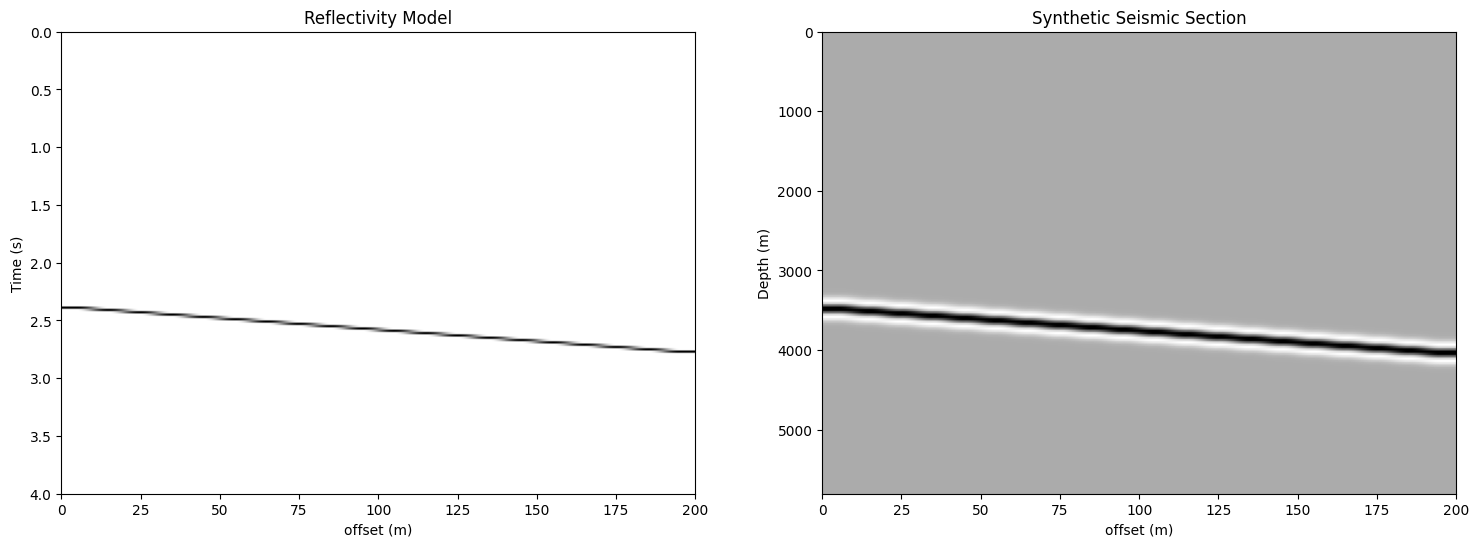

In [5]:
# SYNTHETIC SEISMIC DATA

# Parameters
nt = 200    # Number of time samples
dt = 0.02   # Sampling interval (seconds)
nz = 20    # Number of traces
dx = 10     # Trace spacing (metres)

# Time and depth axes
time = np.arange(nt) * dt
offset = np.arange(nz) * dx

# Initialization of variable to save seismic sections (for serveral realizations)
n_realizations = 1
seismic_realizations=np.zeros((n_realizations, nt, nz))
seismic_realizations_depth=np.zeros((n_realizations, nt, nz))

# For loop for serveral realizations
for i in range(n_realizations):
    # Velocity model
    v = 1500 + np.random.normal(0, 150) # Velocity in m/s

    depth = time * v

    # Reflectivity model (2D grid with reflectors)
    reflectivity = np.zeros((nt, nz))

    ## Horizontal reflector
    #reflector_depth = int(2500 / (v * dt))
    #reflectivity[reflector_depth, :] = 0.7  # Reflectivity coefficient

    ## Horizontal reflector 2
    #reflector_depth_2 = int(1500 / (v * dt))
    #reflectivity[reflector_depth_2, :] = 0.5  # Reflectivity coefficient

    # Dipping reflector
    slope = 1
    intercept_depth = int(3500 / (v * dt))
    for ix in range(nz):
        depth_idx = intercept_depth + int(ix * slope)
        if depth_idx < nt:  # Ensure we don't go out of bounds
            reflectivity[depth_idx, ix] = 0.9  # Reflectivity coefficient

    ## Dipping reflector 2
    #slope_2 = 1
    #intercept_depth_2 = int(4500 / (v * dt))
    #for ix in range(nz):
    #    depth_idx = intercept_depth_2 + int(ix * slope)
    #    if depth_idx < nt:  # Ensure we don't go out of bounds
    #        reflectivity[depth_idx, ix] = 0.5  # Reflectivity coefficient

    # Ricker wavelet from SciPy
    f0 = 10  # Dominant frequency (Hz)
    wavelet = ricker(nt/10, f0 * dt * 10)

    # Convolution of wavelet with reflectivity model to get each trace
    #seismic = np.apply_along_axis(lambda trace: np.convolve(trace, wavelet, mode='same'), axis=0, arr=reflectivity)
    seismic_list = []
    seismic_list_depth = []
    for j in range(reflectivity.shape[1]):
        trace = reflectivity[:, j]
        convolved_trace = np.convolve(trace, wavelet, mode='same')
        # Trace depth conversion
        convolved_trace_depth = convolved_trace * v
        seismic_list.append(convolved_trace)
        seismic_list_depth.append(convolved_trace_depth)

    seismic = np.array(seismic_list).T
    seismic_depth = np.array(seismic_list_depth).T

    # Noise
    noise = 0.0 * np.random.randn(nt, nz)

    # Saving of each seismic section in an array
    seismic_realizations[i] = seismic + noise
    seismic_realizations_depth[i] = seismic + noise


# Plots
plt.figure(figsize=(18, 6))

# Plot of Reflectivity Model
plt.subplot(1, 2, 1)
plt.imshow(reflectivity, cmap='gray_r', aspect='auto', extent=[0, nz * dx, nt * dt, 0])
plt.title('Reflectivity Model')
plt.xlabel('offset (m)')
plt.ylabel('Time (s)')

# Plot of Seismic Section
plt.subplot(1, 2, 2)
plt.imshow(np.sum(seismic_realizations_depth, axis=0), cmap='gray_r', aspect='auto', extent=[0, nz * dx, np.max(depth), 0]) # or nt * dt
plt.title('Synthetic Seismic Section')
plt.xlabel('offset (m)')
plt.ylabel('Depth (m)')
plt.show()

d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Similarity = True


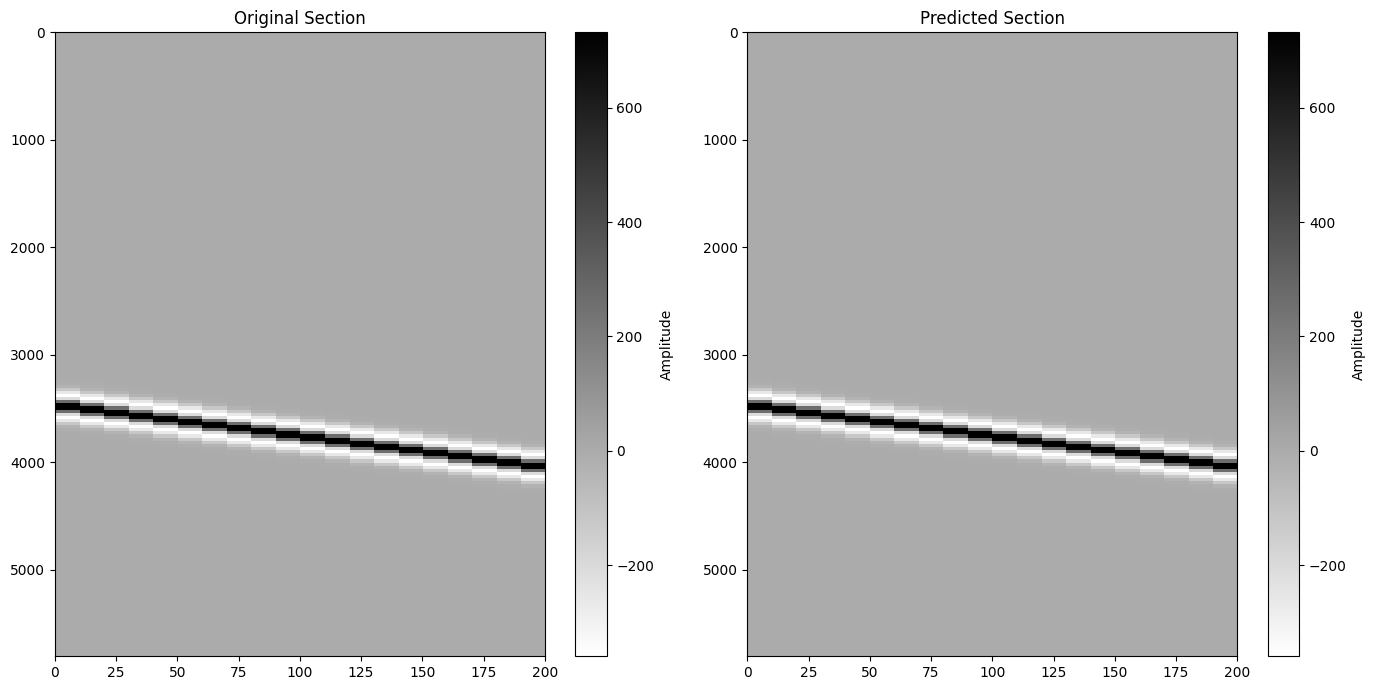

In [16]:
# PREDICTION OF THE SEISMIC EVENT USING A GAUSSIAN PROCESS

# Grid with seismic data
grid = np.zeros((200, 20))
#grid[100, :] = 1  # Set row 100 to 1, all others are 0
grid = seismic_depth

# Covariance function with RBF
# RBF Kernel requires a length scale. Let's set one.
length_scale = 10.0  # Adjust for different smoothness of the covariance
kernel = RBF(length_scale=length_scale)

# Grid for prediction
x = np.linspace(0, 20, 20)
y = np.linspace(0, 200, 200)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T  # Flatten into a 2D array of coordinates

# Flattened seismic (targets for the Gaussian process)
grid_flat = grid.ravel()

# Gaussian Process fit to the seismic data
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)  # Use small noise term
gp.fit(grid_points, grid_flat)  # Fit the GP to the original grid

# Prediction on the prediction grid
predicted_grid_flat, predicted_std = gp.predict(grid_points, return_std=True)
predicted_grid = predicted_grid_flat.reshape(200, 20)  # Reshape back to 200x20 grid


# Similarity check
similarity = np.allclose(grid, predicted_grid, atol=0.1)  # Compare with a tolerance of 0.1
print(f"Similarity = {similarity}")


# Plots
plt.figure(figsize=(14, 7))

# Original grid - Seismic data
plt.subplot(1, 2, 1)
plt.title('Original Section')
#plt.contourf(X, Y, grid, levels=50, cmap='coolwarm')
plt.imshow(grid, cmap='gray_r', aspect='auto', extent=[0, nz * dx, np.max(depth), 0]) # or nt * dt
plt.colorbar(label='Amplitude')

# Predicted grid
plt.subplot(1, 2, 2)
plt.title('Predicted Section')
#plt.contourf(X, Y, predicted_grid, levels=50, cmap='gray_r')
plt.gca().invert_yaxis()
plt.imshow(predicted_grid, cmap='gray_r', aspect='auto', extent=[0, nz * dx, np.max(depth), 0]) # or nt * dt
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

In [43]:
grid_points[i].reshape((1,2))

array([[0., 0.]])

C:\Users\cco\AppData\Local\Temp\ipykernel_24740\3337785534.py:86: RuntimeWarning: invalid value encountered in sqrt
  simulated_value = np.random.normal(mean, np.sqrt(variance))


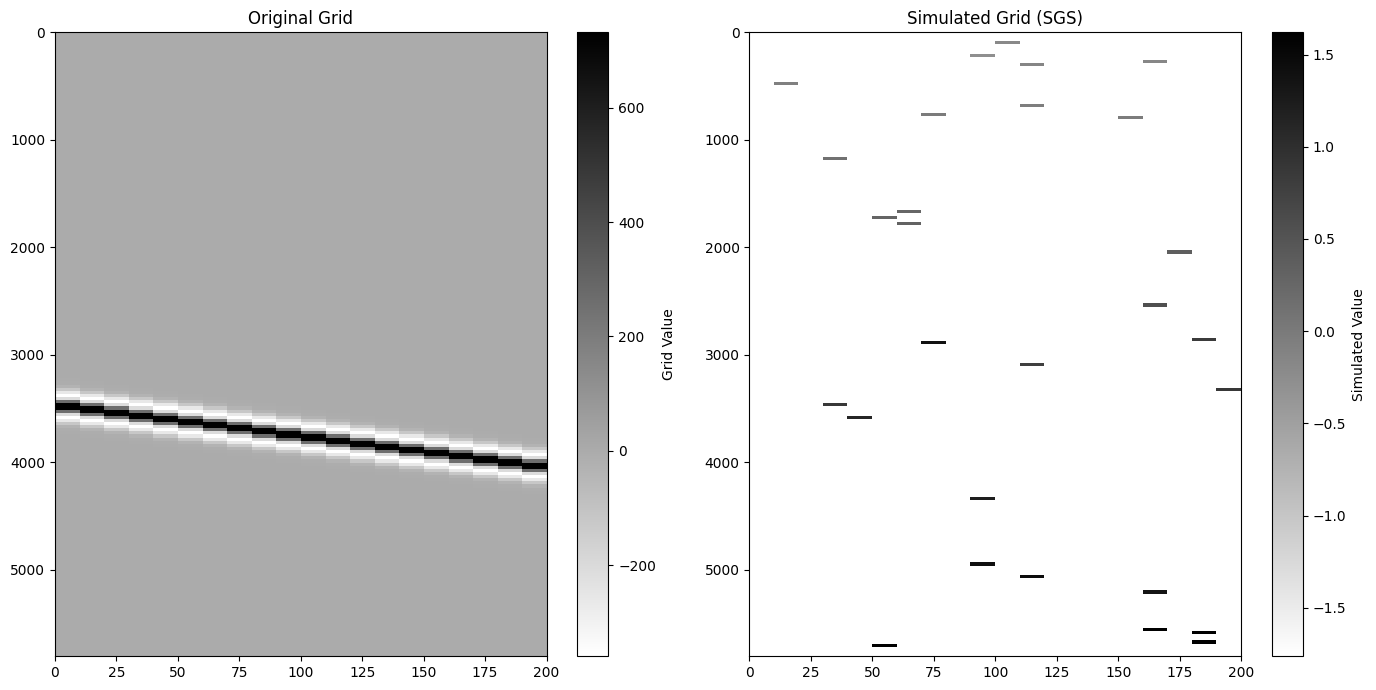

In [45]:
# PREDICTION OF THE SEISMIC EVENT USING SEQUENTIAL GAUSSIAN SIMULATION

# Grid with seismic data
grid = np.zeros((200, 20))
grid[100, :] = 1  # Set row 100 to 1, all others are 0
grid = seismic_depth

# Covariance function with RBF
def rbf_covariance(x, y, length_scale=2000):
    """RBF covariance function"""
    distance = np.linalg.norm(x - y)
    return np.exp(- (distance**2) / (2 * length_scale**2))

# Anisotropic Gaussian covariance function
def anisotropic_gaussian_covariance(h, range_param, sill, anisotropy_ratio, angle):
    # Rotation transformation to account for anisotropy and direction
    theta = np.deg2rad(angle)  # Convert angle to radians
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    # Scale the distances by the anisotropy ratio
    h_transformed = h @ R.T
    h_transformed[:, 0] /= anisotropy_ratio  # Apply the anisotropy scaling
    h_scaled = np.linalg.norm(h_transformed, axis=1)
    return sill * np.exp(-0.5 * (h_scaled / range_param) ** 2)

# Covariance model parameters
range_param = 100.0  # Range of spatial correlation
sill = 20.0          # Variance (sill)
anisotropy_ratio = 100  # Ratio of anisotropy (greater than 1 stretches horizontally)
angle = 18  # Angle of anisotropy (0 degrees = x-axis)


# Sequential Gaussian Simulation

## Grid for prediction
#x = np.linspace(0, 200, 20)
#y = np.linspace(0, 2000, 200)
#X, Y = np.meshgrid(x, y)
#grid_points = np.vstack([X.ravel(), Y.ravel()]).T  # Flatten into a 2D array of coordinates

# Total number of grid points
n_points = grid_points.shape[0]

# Initialization of the simulated grid with NaNs (for unsimulated points)
simulated_grid = np.full(n_points, np.nan)

# Sequential simulation for each point
cov_matrix = np.zeros((n_points, n_points))
for i in range(n_points):
    for j in range(n_points):
        # Covariance function, enable/disable as needed
        cov_matrix[i, j] = rbf_covariance(grid_points[i], grid_points[j])
        #cov_matrix[i, j] = anisotropic_gaussian_covariance(
        #    cdist(grid_points[i], grid_points[j]),
        #    range_param,
        #    sill,
        #    anisotropy_ratio,
        #    angle
        #    )

# Cholesky decomposition (for faster sampling)
L = cholesky(cov_matrix + 1e-6 * np.eye(n_points), lower=True)  # Small jitter for numerical stability

# Random order of points to simulate
np.random.seed(42)
points_order = np.random.permutation(n_points)

# Loop over points and simulation on each point
for idx in points_order:
    # Simulation of current point using conditional distribution
    already_simulated = ~np.isnan(simulated_grid)  # Points already simulated
    if np.sum(already_simulated) == 0:
        # If no simulated points, sample from the prior
        simulated_value = np.random.normal(0, 1)
    else:
        # Covariances for already simulated points and current point
        cov_known = cov_matrix[idx, already_simulated]
        cov_known_known = cov_matrix[np.ix_(already_simulated, already_simulated)]
        cov_self = cov_matrix[idx, idx]

        # Mean and variance of the conditional distribution
        mean = cov_known @ np.linalg.inv(cov_known_known) @ simulated_grid[already_simulated]
        variance = cov_self - cov_known @ np.linalg.inv(cov_known_known) @ cov_known

        # Sample from the normal distribution
        simulated_value = np.random.normal(mean, np.sqrt(variance))

    # Assignation of simulated value to current grid point
    simulated_grid[idx] = simulated_value

# Reshape to original shape
simulated_grid_reshaped = simulated_grid.reshape(200, 20)


# Similarity check
#similarity = np.allclose(grid, simulated_grid_reshaped, atol=0.1)  # Compare with a tolerance of 0.1
#print(f"Similarity = {similarity}")

# Plots
plt.figure(figsize=(14, 7))

# Original grid - Seismic data
plt.subplot(1, 2, 1)
plt.title('Original Grid')
#plt.contourf(X, Y, grid, levels=50, cmap='coolwarm')
#plt.gca().invert_yaxis()
plt.imshow(grid, cmap='gray_r', aspect='auto', extent=[0, nz * dx, np.max(depth), 0]) # or nt * dt
plt.colorbar(label='Grid Value')

# Predicted grid
plt.subplot(1, 2, 2)
plt.title('Simulated Grid (SGS)')
#plt.contourf(X, Y, simulated_grid_reshaped, levels=50, cmap='coolwarm')
#plt.gca().invert_yaxis()
plt.imshow(simulated_grid_reshaped, cmap='gray_r', aspect='auto', extent=[0, nz * dx, np.max(depth), 0]) # or nt * dt
plt.colorbar(label='Simulated Value')
plt.tight_layout()

plt.show()

d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\sklearn\gaussian_process\kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


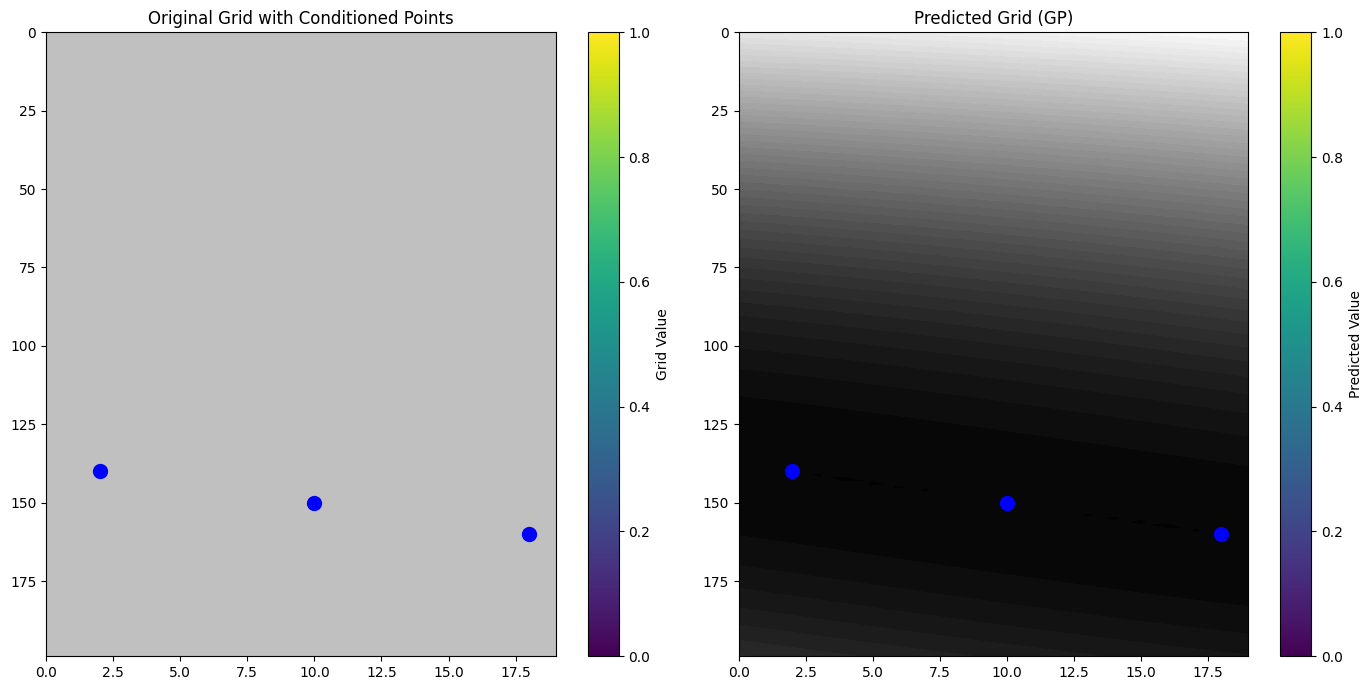

In [11]:
# CONDITIONED PREDICTION OF THE SEISMIC EVENT USING A GAUSSIAN PROCESS

# Grid FOR seismic data
grid = np.zeros((200, 20))

# Observed data - Input points
x_train = np.array([[3500/5000*200, 2], [3750/5000*200, 10], [4000/5000*200, 18]])
y_train = np.array([1, 1, 1])

# Grid for prediction
X = np.array([[i, j] for i in range(200) for j in range(20)])  # Flattened grid into coordinates

# Gaussian process kernel
kernel = RBF(length_scale=20.0, length_scale_bounds=(1e-1, 100.0))

# Gaussian Process fit to the input data (reflector)
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(x_train, y_train)

# Prediction on the prediction grid
y_pred, sigma = gp.predict(X, return_std=True)
predicted_grid = y_pred.reshape(200, 20)


# Plots

plt.figure(figsize=(14, 7))

# Original grid - Input data
plt.subplot(1, 2, 1)
plt.title('Original Grid with Conditioned Points')
plt.contourf(np.arange(20), np.arange(200), grid, levels=50, cmap='gray_r')
plt.scatter(x_train[:, 1], x_train[:, 0], c='blue', marker='o', s=100, label='Input Points')
plt.gca().invert_yaxis()
plt.colorbar(label='Grid Value')

# Predicted grid
plt.subplot(1, 2, 2)
plt.title('Predicted Grid (GP)')
plt.contourf(np.arange(20), np.arange(200), predicted_grid, levels=50, cmap='gray_r')
plt.scatter(x_train[:, 1], x_train[:, 0], c='blue', marker='o', s=100, label='Input Points')
plt.gca().invert_yaxis()
plt.colorbar(label='Predicted Value')

plt.tight_layout()
plt.show()


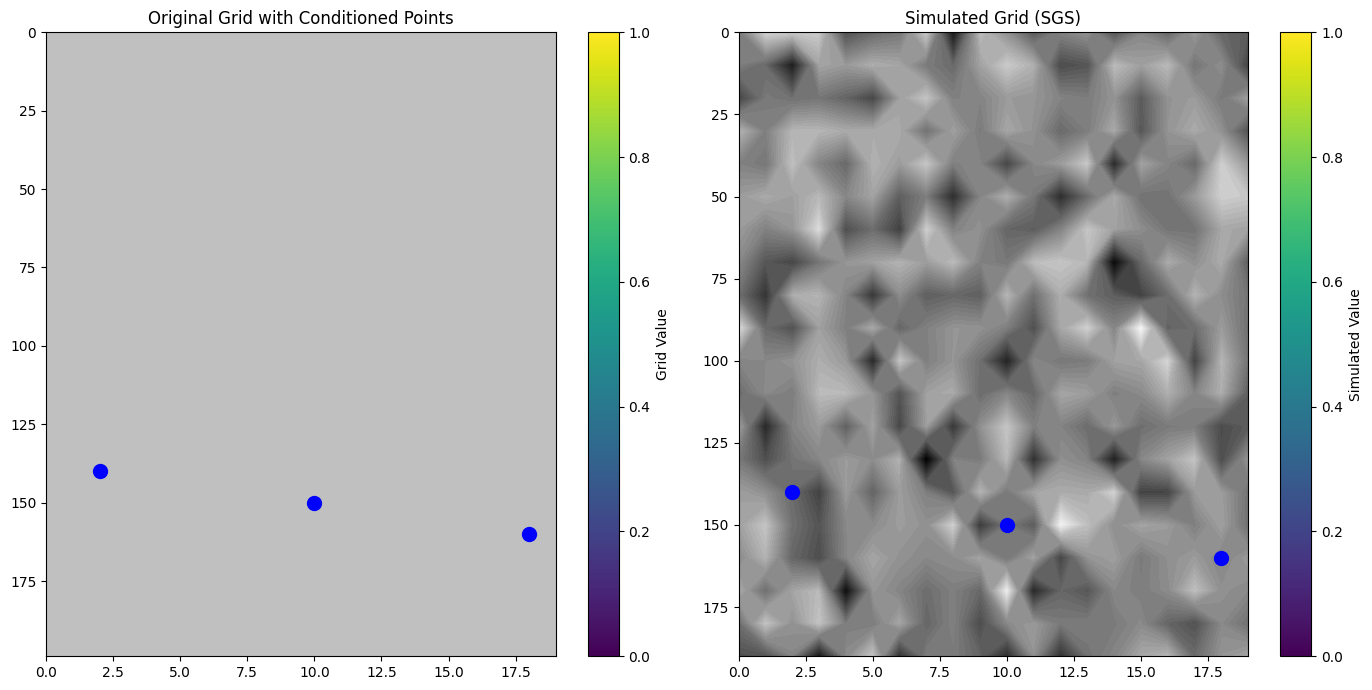

In [12]:
# CONDITIONED PREDICTION OF THE SEISMIC EVENT USING A SEQUENTIAL GAUSSIAN SIMULATION

# Grid for seismic data
grid = np.zeros((200, 20))

# Observed data - Input points
x_train = np.array([[3500/5000*200, 2], [3750/5000*200, 10], [4000/5000*200, 18]])
y_train = np.array([1, 1, 1])

# Grid for prediction
x = np.linspace(0, 20, 20)
y = np.linspace(0, 200, 20)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T  # Create list of grid points

# Covariance function, exponential
def covariance(x1, x2, length_scale=20.0):
    return np.exp(-np.linalg.norm(x1 - x2) / length_scale)

# Sequential Gaussian Simulation

# Initialize grid for prediction
predicted_grid = np.zeros(len(grid_points))

for i, point in enumerate(grid_points):
    known_points = np.vstack([x_train, grid_points[:i]])
    cov_matrix = np.zeros((len(known_points), len(known_points)))
    
    # Covariance matrix
    for j in range(len(known_points)):
        for k in range(len(known_points)):
            cov_matrix[j, k] = covariance(known_points[j], known_points[k])
    
    # Cholesky decomposition
    L = cholesky(cov_matrix + 1e-8 * np.eye(len(cov_matrix)), lower=True)
    
    # Simulation for new point
    predicted_grid[i] = np.dot(L, np.random.randn(len(L)))[-1]


# Reshape to original shape
predicted_grid = predicted_grid.reshape(20, 20)


# Plots
plt.figure(figsize=(14, 7))

# Original grid - Conditioning points
plt.subplot(1, 2, 1)
plt.title('Original Grid with Conditioned Points')
plt.contourf(np.arange(20), np.arange(200), grid, levels=50, cmap='gray_r')
plt.scatter(x_train[:, 1], x_train[:, 0], c='blue', marker='o', s=100, label='Input Points')
plt.gca().invert_yaxis()
plt.colorbar(label='Grid Value')

# Predicted grid
plt.subplot(1, 2, 2)
plt.title('Simulated Grid (SGS)')
plt.contourf(np.arange(20), np.arange(0, 200, 10), predicted_grid, levels=50, cmap='gray_r')
plt.scatter(x_train[:, 1], x_train[:, 0], c='blue', marker='o', s=100, label='Input Points')
plt.gca().invert_yaxis()
plt.colorbar(label='Simulated Value')

plt.tight_layout()
plt.show()
